In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)
%cd /content/drive/MyDrive/NEXCO/src/EDA/

Mounted at /content/drive
/content/drive/MyDrive/NEXCO/src/EDA


In [2]:
!pip install japanize_matplotlib jpholiday

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 55.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=d7ea74148458975b7e47e6ae2ebb34aa60a14e45a7de5e403162ff3460896ae5
  Stored in directory: /root/.cache/pip/wheels/91/8f/c2/83055ad0c9591b0a094730aa7cb2cc12fedacbcd2241baf534
Successfully built japanize_matplotlib


In [3]:
# ========================================
# Library
# ========================================
import os
import math
import random
import pickle
import itertools
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import datetime
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import jpholiday
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    KFold,
    GroupKFold,
    StratifiedGroupKFold
)# StratifiedGroupKFold, 
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from scipy.optimize import minimize
import lightgbm as lgb

pd.set_option('display.max_columns', None)

def set_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
set_seed()

In [4]:
train_df = pd.read_csv("../train/train.csv")
search_spec_df = pd.read_csv("../train/search_data.csv")
search_unspec_df = pd.read_csv("../train/search_unspec_data.csv")
road_df = pd.read_csv("../train/road.csv")

In [5]:
train_df.columns

Index(['datetime', 'start_code', 'end_code', 'OCC', 'allCars', 'speed',
       'is_congestion'],
      dtype='object')

In [6]:
train_df.shape
train_df.columns = ['datetime', 'start_code', 'end_code', 'OCC_ysd', 'allCars_ysd', 'speed', 'is_congestion']

In [7]:
train_df.head(5)# (910080, 7)

,datetime,start_code,end_code,OCC_ysd,allCars_ysd,speed,is_congestion
0,2021-04-08 00:00:00,1110210,1800006,2.083333,510,80.712329,0
1,2021-04-08 01:00:00,1110210,1800006,1.500000,433,81.730415,0
2,2021-04-08 02:00:00,1110210,1800006,1.333333,366,81.288828,0
3,2021-04-08 03:00:00,1110210,1800006,1.500000,426,82.953162,0
4,2021-04-08 04:00:00,1110210,1800006,1.833333,498,82.430862,0


In [8]:
search_spec_df.shape

(910080, 4)

In [9]:
search_spec_df.head(5)# (910080, 4)

,datetime,start_code,end_code,search_1h
0,2021-04-08 00:00:00,1110210,1800006,15.0
1,2021-04-08 01:00:00,1110210,1800006,6.0
2,2021-04-08 02:00:00,1110210,1800006,3.0
3,2021-04-08 03:00:00,1110210,1800006,26.0
4,2021-04-08 04:00:00,1110210,1800006,31.0


In [10]:
search_spec_df.tail(5)

,datetime,start_code,end_code,search_1h
910075,2022-07-31 19:00:00,1130046,1130041,0.0
910076,2022-07-31 20:00:00,1130046,1130041,0.0
910077,2022-07-31 21:00:00,1130046,1130041,0.0
910078,2022-07-31 22:00:00,1130046,1130041,0.0
910079,2022-07-31 23:00:00,1130046,1130041,0.0


In [11]:
search_unspec_df.shape

(37920, 4)

In [12]:
search_unspec_df.head(5)# (37920, 4)

,date,start_code,end_code,search_unspec_1d
0,2021-04-08,1110210,1800006,3448.0
1,2021-04-09,1110210,1800006,2992.0
2,2021-04-10,1110210,1800006,2970.0
3,2021-04-11,1110210,1800006,2992.0
4,2021-04-12,1110210,1800006,2974.0


In [13]:
search_unspec_df.tail(5)

,date,start_code,end_code,search_unspec_1d
37915,2022-07-27,1800183,1800176,705.0
37916,2022-07-28,1800183,1800176,704.0
37917,2022-07-29,1800183,1800176,670.0
37918,2022-07-30,1800183,1800176,676.0
37919,2022-07-31,1800183,1800176,746.0


In [14]:
road_df.shape

(79, 18)

In [15]:
road_df.head(5)# (79, 18)

,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,direction,start_KP,end_KP,limit_speed,road_code
0,大泉ＪＣＴ,所沢,1110210,1800006,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.90,下り,0.0,9.4,100,1800
1,京葉道路・館山自動車道接続部,市原,1130001,1130006,12,12,35.55136,35.49471,140.143014,140.094986,2.0,2.0,39.17,下り,35.7,43.7,100,1130
2,市原,京葉道路・館山自動車道接続部,1130006,1130001,12,12,35.49471,35.55136,140.094986,140.143014,2.0,2.0,39.17,上り,43.7,35.7,100,1130
3,市原,姉崎袖ヶ浦,1130006,1130016,12,12,35.49471,35.42603,140.094986,140.045153,2.0,2.0,46.27,下り,43.7,53.7,100,1130
4,姉崎袖ヶ浦,市原,1130016,1130006,12,12,35.42603,35.49471,140.045153,140.094986,2.0,2.0,46.27,上り,53.7,43.7,100,1130


In [16]:
def expand_datetime(df):
    if 'datetime' in df.columns:
        df['year'] = df['datetime'].dt.year
        df['month'] = df['datetime'].dt.month
        df['day'] = df['datetime'].dt.day
        df['hour'] = df['datetime'].dt.hour
    if 'date' in df.columns:
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
    return df

def extract_dataset(train_df, search_spec_df, search_unspec_df):
    train_df['datetime'] = pd.to_datetime(train_df['datetime'])
    search_spec_df['datetime'] = pd.to_datetime(search_spec_df['datetime'])
    search_unspec_df['date'] = pd.to_datetime(search_unspec_df['date'])
    # 当日の検索数を利用 << 目的変数をずらすから解決
    # search_spec_df['datetime'] -= pd.to_timedelta(1, 'd')
    # search_unspec_df['date'] -= pd.to_timedelta(1, 'd')

    train_df = expand_datetime(train_df)
    # search_spec_df = expand_datetime(search_spec_df)
    search_unspec_df = expand_datetime(search_unspec_df)

    class TestHoliday(jpholiday.OriginalHoliday):
        def _is_holiday(self, date):
            extra_holidays = [
                #GW
                datetime.date(2021, 4, 29), datetime.date(2022, 4, 29), datetime.date(2023, 4, 29),
                datetime.date(2021, 4, 30), datetime.date(2022, 4, 30), datetime.date(2023, 4, 30),
                datetime.date(2021, 5, 1), datetime.date(2022, 5, 1), datetime.date(2023, 5, 1),
                datetime.date(2021, 5, 2), datetime.date(2022, 5, 2), datetime.date(2023, 5, 2),
                datetime.date(2021, 5, 3), datetime.date(2022, 5, 3), datetime.date(2023, 5, 3),
                datetime.date(2021, 5, 4), datetime.date(2022, 5, 4), datetime.date(2023, 5, 4),
                datetime.date(2021, 5, 5), datetime.date(2022, 5, 5), datetime.date(2023, 5, 5),

                # お盆
                datetime.date(2021, 8, 13), datetime.date(2022, 8, 13), datetime.date(2023, 8, 13),
                datetime.date(2021, 8, 14), datetime.date(2022, 8, 14), datetime.date(2023, 8, 14),
                datetime.date(2021, 8, 15), datetime.date(2022, 8, 15), datetime.date(2023, 8, 15),

                #年末年始
                datetime.date(2021, 12, 31), datetime.date(2022, 12, 31), datetime.date(2023, 12, 31),
                datetime.date(2021, 1, 1), datetime.date(2022, 1, 1), datetime.date(2023, 1, 1),
                datetime.date(2021, 1, 2), datetime.date(2022, 1, 2), datetime.date(2023, 1, 2),
                datetime.date(2021, 1, 3), datetime.date(2022, 1, 3), datetime.date(2023, 1, 3),
            ]
            if date in extra_holidays:
                return True
            return False

    def is_jpholiday(date):
        if jpholiday.is_holiday(date) or 5<=date.weekday():
            return True
        else:
            return False
    search_unspec_df['is_holiday'] = search_unspec_df['date'].map(is_jpholiday)
    search_unspec_df['is_holiday'] = search_unspec_df['is_holiday'].astype(int)# is_holiday = jpholiday.is_holiday(date)

    train_df = train_df.merge(search_spec_df, on=['datetime', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(search_unspec_df, on=['year', 'month', 'day', 'start_code', 'end_code'], how='left')
    train_df = train_df.merge(road_df.drop(['start_name', 'end_name'], axis=1), on=['start_code', 'end_code'], how='left')

    train_df['dayofweek'] = train_df['datetime'].dt.weekday

    train_df['section'] = train_df['start_code'].astype(str)+'_'+train_df['end_code'].astype(str)

    train_df['straight_dist'] = np.sqrt( (train_df['end_lat']-train_df['start_lat'])**2 + (train_df['end_lng']-train_df['start_lng'])**2 ) * 100
    train_df['KP_se_dist'] = np.abs(train_df['end_KP']-train_df['start_KP'])
    train_df['KP_te_dist'] = np.abs(train_df['end_KP']-train_df['KP'])
    train_df['KP_st_dist'] = np.abs(train_df['KP']-train_df['start_KP'])
    train_df['KP_max_dist'] = np.max(train_df[['KP_te_dist', 'KP_st_dist']], axis=1) / train_df['KP_se_dist']
    train_df['detour_rate'] = train_df['KP_se_dist']/train_df['straight_dist']

    train_df.sort_values(['section', 'datetime'])
    train_df[['speed', 'is_congestion']] = train_df.groupby('section').shift(-24).reset_index()[['speed', 'is_congestion']]
    train_df[['datetime_td', 'year_td', 'month_td', 'day_td', 'is_holiday_td', 'dayofweek_td']] = train_df.groupby('section').shift(-24).reset_index()[['datetime', 'year', 'month', 'day', 'is_holiday', 'dayofweek']]
    train_df['degree_diss_es'] = train_df['end_degree'] - train_df['start_degree']
    train_df['season'] = train_df['month_td'].apply(lambda x: (x % 12 + 3) // 3)

    return train_df

In [17]:
train = extract_dataset(train_df, search_spec_df, search_unspec_df)

In [18]:
'''
train                     :    (910080, 7) << 時間(24h*480d*79section), sid, eid, 車線占有率, 通過台数, スピード平均, 目的変数(渋滞orNot)
search                 :     (910080, 4) <<  時間(24h*480d*79section), sid, eid, 検索数
search_unspec           :    (37920, 4)  << 日付(480d*79section)     , sid, eid, 検索数
road                     :    (79, 18)         <<  sid, s名, s県id, s緯度, s経度, s接続IC数, sKP
                                                    eid, e名, e県id, e緯度, e経度, e接続IC数, eKP
                                                    上りor下り, TKP, 制限速度, 道路コード(関越道:1800、館山道:1130)
                                                                
                                    KP<起点からの距離(関越道起点は大泉JCT（練馬IC）、館山道起点は篠崎IC（京葉道路)
train_df, search_df, search_unspec_df, road_df

79section * 24 = 1896 (1日のレコード数)

train < 時間 > search
train < 日付 > search_unspec
train < sid, eid > road

all_df >> 15+18


train >> 前日までの (speedとis_congestionだけ当日の)
search >> 当日の

'''

'\ntrain                     :    (910080, 7) << 時間(24h*480d*79section), sid, eid, 車線占有率, 通過台数, スピード平均, 目的変数(渋滞orNot)\nsearch                 :     (910080, 4) <<  時間(24h*480d*79section), sid, eid, 検索数\nsearch_unspec           :    (37920, 4)  << 日付(480d*79section)     , sid, eid, 検索数\nroad                     :    (79, 18)         <<  sid, s名, s県id, s緯度, s経度, s接続IC数, sKP\n                                                    eid, e名, e県id, e緯度, e経度, e接続IC数, eKP\n                                                    上りor下り, TKP, 制限速度, 道路コード(関越道:1800、館山道:1130)\n                                                                \n                                    KP<起点からの距離(関越道起点は大泉JCT（練馬IC）、館山道起点は篠崎IC（京葉道路)\ntrain_df, search_df, search_unspec_df, road_df\n\n79section * 24 = 1896 (1日のレコード数)\n\ntrain < 時間 > search\ntrain < 日付 > search_unspec\ntrain < sid, eid > road\n\nall_df >> 15+18\n\n\ntrain >> 前日までの (speedとis_congestionだけ当日の)\nsearch >> 当日の\n\n'

In [19]:
train[['datetime', 'dayofweek', 'is_holiday', 'datetime_td', 'dayofweek_td', 'is_holiday_td', 'is_congestion', 'search_1h', 'search_unspec_1d', 'OCC_ysd', 'allCars_ysd']].tail(30)

,datetime,dayofweek,is_holiday,datetime_td,dayofweek_td,is_holiday_td,is_congestion,search_1h,search_unspec_1d,OCC_ysd,allCars_ysd
910050,2022-07-30 18:00:00,5,1,2022-07-31 18:00:00,6.0,1.0,0.0,0.0,81.0,2.666667,662
910051,2022-07-30 19:00:00,5,1,2022-07-31 19:00:00,6.0,1.0,0.0,0.0,81.0,2.416667,591
910052,2022-07-30 20:00:00,5,1,2022-07-31 20:00:00,6.0,1.0,0.0,0.0,81.0,1.666667,384
910053,2022-07-30 21:00:00,5,1,2022-07-31 21:00:00,6.0,1.0,0.0,0.0,81.0,1.166667,252
910054,2022-07-30 22:00:00,5,1,2022-07-31 22:00:00,6.0,1.0,0.0,0.0,81.0,0.666667,120
910055,2022-07-30 23:00:00,5,1,2022-07-31 23:00:00,6.0,1.0,0.0,0.0,81.0,0.750000,113
910056,2022-07-31 00:00:00,6,1,NaT,NaN,NaN,NaN,1.0,119.0,0.666667,92
910057,2022-07-31 01:00:00,6,1,NaT,NaN,NaN,NaN,0.0,119.0,0.333333,52
910058,2022-07-31 02:00:00,6,1,NaT,NaN,NaN,NaN,0.0,119.0,0.333333,51
910059,2022-07-31 03:00:00,6,1,NaT,NaN,NaN,NaN,0.0,119.0,0.000000,29


In [20]:
train.columns

Index(['datetime', 'start_code', 'end_code', 'OCC_ysd', 'allCars_ysd', 'speed',
       'is_congestion', 'year', 'month', 'day', 'hour', 'search_1h', 'date',
       'search_unspec_1d', 'is_holiday', 'start_pref_code', 'end_pref_code',
       'start_lat', 'end_lat', 'start_lng', 'end_lng', 'start_degree',
       'end_degree', 'KP', 'direction', 'start_KP', 'end_KP', 'limit_speed',
       'road_code', 'dayofweek', 'section', 'straight_dist', 'KP_se_dist',
       'KP_te_dist', 'KP_st_dist', 'KP_max_dist', 'detour_rate', 'datetime_td',
       'year_td', 'month_td', 'day_td', 'is_holiday_td', 'dayofweek_td',
       'degree_diss_es', 'season'],
      dtype='object')

In [21]:
cat_cols = ['road_code', 'start_code', 'end_code', 'section', 'direction', 'dayofweek', 'is_holiday', 'is_holiday_td', 'start_pref_code', 'end_pref_code', 'season']
num_cols = ['year', 'month', 'day', 'year_td', 'month_td', 'day_td', 'hour', 'search_1h', 'search_unspec_1d', 'KP', 'start_KP', 'end_KP', 'limit_speed', \
            'straight_dist', 'KP_se_dist', 'KP_te_dist', 'KP_st_dist', 'KP_max_dist', 'detour_rate', 'start_degree', 'end_degree', 'degree_diss_es', 'OCC_ysd', 'allCars_ysd']
feature_cols = cat_cols + num_cols

In [22]:
train.head(30)

,datetime,start_code,end_code,OCC_ysd,allCars_ysd,speed,is_congestion,year,month,day,hour,search_1h,date,search_unspec_1d,is_holiday,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,direction,start_KP,end_KP,limit_speed,road_code,dayofweek,section,straight_dist,KP_se_dist,KP_te_dist,KP_st_dist,KP_max_dist,detour_rate,datetime_td,year_td,month_td,day_td,is_holiday_td,dayofweek_td,degree_diss_es,season
0,2021-04-08 00:00:00,1110210,1800006,2.083333,510,82.052209,0.0,2021,4,8,0,15.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491,2021-04-09 00:00:00,2021.0,4.0,9.0,0.0,4.0,-2.0,2.0
1,2021-04-08 01:00:00,1110210,1800006,1.500000,433,82.892617,0.0,2021,4,8,1,6.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491,2021-04-09 01:00:00,2021.0,4.0,9.0,0.0,4.0,-2.0,2.0
2,2021-04-08 02:00:00,1110210,1800006,1.333333,366,82.874359,0.0,2021,4,8,2,3.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491,2021-04-09 02:00:00,2021.0,4.0,9.0,0.0,4.0,-2.0,2.0
3,2021-04-08 03:00:00,1110210,1800006,1.500000,426,82.596603,0.0,2021,4,8,3,26.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491,2021-04-09 03:00:00,2021.0,4.0,9.0,0.0,4.0,-2.0,2.0
4,2021-04-08 04:00:00,1110210,1800006,1.833333,498,83.952984,0.0,2021,4,8,4,31.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491,2021-04-09 04:00:00,2021.0,4.0,9.0,0.0,4.0,-2.0,2.0
5,2021-04-08 05:00:00,1110210,1800006,3.916667,1283,85.781560,0.0,2021,4,8,5,31.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491,2021-04-09 05:00:00,2021.0,4.0,9.0,0.0,4.0,-2.0,2.0
6,2021-04-08 06:00:00,1110210,1800006,10.583333,3343,75.749415,0.0,2021,4,8,6,40.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491,2021-04-09 06:00:00,2021.0,4.0,9.0,0.0,4.0,-2.0,2.0
7,2021-04-08 07:00:00,1110210,1800006,11.166667,3577,69.484674,0.0,2021,4,8,7,31.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491,2021-04-09 07:00:00,2021.0,4.0,9.0,0.0,4.0,-2.0,2.0
8,2021-04-08 08:00:00,1110210,1800006,9.583333,3290,78.237214,0.0,2021,4,8,8,21.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491,2021-04-09 08:00:00,2021.0,4.0,9.0,0.0,4.0,-2.0,2.0
9,2021-04-08 09:00:00,1110210,1800006,8.750000,2966,74.427483,0.0,2021,4,8,9,27.0,2021-04-08,3448.0,0,13,11,35.75582,35.80615,139.601514,139.535511,4.0,2.0,3.9,下り,0.0,9.4,100,1800,3,1110210_1800006,8.300286,9.4,5.5,3.9,0.585106,1.132491,2021-04-09 09:00:00,2021.0,4.0,9.0,0.0,4.0,-2.0,2.0


In [23]:
train.tail(30)

,datetime,start_code,end_code,OCC_ysd,allCars_ysd,speed,is_congestion,year,month,day,hour,search_1h,date,search_unspec_1d,is_holiday,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,direction,start_KP,end_KP,limit_speed,road_code,dayofweek,section,straight_dist,KP_se_dist,KP_te_dist,KP_st_dist,KP_max_dist,detour_rate,datetime_td,year_td,month_td,day_td,is_holiday_td,dayofweek_td,degree_diss_es,season
910050,2022-07-30 18:00:00,1130046,1130041,2.666667,662,94.113341,0.0,2022,7,30,18,0.0,2022-07-30,81.0,1,12,12,35.19397,35.24851,139.862353,139.89325,2.0,2.0,83.025,上り,87.2,79.7,100,1130,5,1130046_1130041,6.268373,7.5,3.325,4.175,0.556667,1.196483,2022-07-31 18:00:00,2022.0,7.0,31.0,1.0,6.0,0.0,3.0
910051,2022-07-30 19:00:00,1130046,1130041,2.416667,591,94.606884,0.0,2022,7,30,19,0.0,2022-07-30,81.0,1,12,12,35.19397,35.24851,139.862353,139.89325,2.0,2.0,83.025,上り,87.2,79.7,100,1130,5,1130046_1130041,6.268373,7.5,3.325,4.175,0.556667,1.196483,2022-07-31 19:00:00,2022.0,7.0,31.0,1.0,6.0,0.0,3.0
910052,2022-07-30 20:00:00,1130046,1130041,1.666667,384,93.445135,0.0,2022,7,30,20,0.0,2022-07-30,81.0,1,12,12,35.19397,35.24851,139.862353,139.89325,2.0,2.0,83.025,上り,87.2,79.7,100,1130,5,1130046_1130041,6.268373,7.5,3.325,4.175,0.556667,1.196483,2022-07-31 20:00:00,2022.0,7.0,31.0,1.0,6.0,0.0,3.0
910053,2022-07-30 21:00:00,1130046,1130041,1.166667,252,96.986885,0.0,2022,7,30,21,0.0,2022-07-30,81.0,1,12,12,35.19397,35.24851,139.862353,139.89325,2.0,2.0,83.025,上り,87.2,79.7,100,1130,5,1130046_1130041,6.268373,7.5,3.325,4.175,0.556667,1.196483,2022-07-31 21:00:00,2022.0,7.0,31.0,1.0,6.0,0.0,3.0
910054,2022-07-30 22:00:00,1130046,1130041,0.666667,120,97.575000,0.0,2022,7,30,22,0.0,2022-07-30,81.0,1,12,12,35.19397,35.24851,139.862353,139.89325,2.0,2.0,83.025,上り,87.2,79.7,100,1130,5,1130046_1130041,6.268373,7.5,3.325,4.175,0.556667,1.196483,2022-07-31 22:00:00,2022.0,7.0,31.0,1.0,6.0,0.0,3.0
910055,2022-07-30 23:00:00,1130046,1130041,0.750000,113,93.431034,0.0,2022,7,30,23,0.0,2022-07-30,81.0,1,12,12,35.19397,35.24851,139.862353,139.89325,2.0,2.0,83.025,上り,87.2,79.7,100,1130,5,1130046_1130041,6.268373,7.5,3.325,4.175,0.556667,1.196483,2022-07-31 23:00:00,2022.0,7.0,31.0,1.0,6.0,0.0,3.0
910056,2022-07-31 00:00:00,1130046,1130041,0.666667,92,NaN,NaN,2022,7,31,0,1.0,2022-07-31,119.0,1,12,12,35.19397,35.24851,139.862353,139.89325,2.0,2.0,83.025,上り,87.2,79.7,100,1130,6,1130046_1130041,6.268373,7.5,3.325,4.175,0.556667,1.196483,NaT,NaN,NaN,NaN,NaN,NaN,0.0,NaN
910057,2022-07-31 01:00:00,1130046,1130041,0.333333,52,NaN,NaN,2022,7,31,1,0.0,2022-07-31,119.0,1,12,12,35.19397,35.24851,139.862353,139.89325,2.0,2.0,83.025,上り,87.2,79.7,100,1130,6,1130046_1130041,6.268373,7.5,3.325,4.175,0.556667,1.196483,NaT,NaN,NaN,NaN,NaN,NaN,0.0,NaN
910058,2022-07-31 02:00:00,1130046,1130041,0.333333,51,NaN,NaN,2022,7,31,2,0.0,2022-07-31,119.0,1,12,12,35.19397,35.24851,139.862353,139.89325,2.0,2.0,83.025,上り,87.2,79.7,100,1130,6,1130046_1130041,6.268373,7.5,3.325,4.175,0.556667,1.196483,NaT,NaN,NaN,NaN,NaN,NaN,0.0,NaN
910059,2022-07-31 03:00:00,1130046,1130041,0.000000,29,NaN,NaN,2022,7,31,3,0.0,2022-07-31,119.0,1,12,12,35.19397,35.24851,139.862353,139.89325,2.0,2.0,83.025,上り,87.2,79.7,100,1130,6,1130046_1130041,6.268373,7.5,3.325,4.175,0.556667,1.196483,NaT,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [24]:
train.shape

(910080, 45)

In [25]:
train = train[~train['is_congestion'].isnull()]

In [26]:
train.shape

(908184, 45)

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 908184 entries, 0 to 910055
Data columns (total 45 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datetime          908184 non-null  datetime64[ns]
 1   start_code        908184 non-null  int64         
 2   end_code          908184 non-null  int64         
 3   OCC_ysd           908184 non-null  float64       
 4   allCars_ysd       908184 non-null  int64         
 5   speed             908184 non-null  float64       
 6   is_congestion     908184 non-null  float64       
 7   year              908184 non-null  int64         
 8   month             908184 non-null  int64         
 9   day               908184 non-null  int64         
 10  hour              908184 non-null  int64         
 11  search_1h         908184 non-null  float64       
 12  date              908184 non-null  datetime64[ns]
 13  search_unspec_1d  908184 non-null  float64       
 14  is_h

In [28]:
train.describe()

,start_code,end_code,OCC_ysd,allCars_ysd,speed,is_congestion,year,month,day,hour,search_1h,search_unspec_1d,is_holiday,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,end_lng,start_degree,end_degree,KP,start_KP,end_KP,limit_speed,road_code,dayofweek,straight_dist,KP_se_dist,KP_te_dist,KP_st_dist,KP_max_dist,detour_rate,year_td,month_td,day_td,is_holiday_td,dayofweek_td,degree_diss_es,season
count,9.081840e+05,9.081840e+05,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.00000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000,908184.000000
mean,1.655645e+06,1.655645e+06,2.603401,872.960672,89.983988,0.004458,2021.440501,6.302714,15.868476,11.50000,22.494475,2062.256653,0.338205,11.696203,11.696203,36.237507,36.237356,139.301040,139.301227,2.202532,2.189873,93.675468,94.317367,94.292051,92.911392,1664.303797,3.006263,6.312220,6.931241,3.657797,3.273443,0.724121,1.087087,2021.442589,6.308977,15.916493,0.340292,3.012526,-0.012658,2.511482
std,2.758517e+05,2.758517e+05,2.570008,871.111272,7.951702,0.066622,0.496448,3.081737,8.725787,6.92219,50.936363,1809.087011,0.473099,1.759995,1.759995,0.609746,0.609727,0.399541,0.399440,0.536745,0.529532,61.921437,62.098440,62.102722,9.566812,269.263953,1.996334,3.483787,3.924388,3.320637,3.277406,0.138075,0.105186,0.496693,3.080099,8.745616,0.473808,2.001005,0.737661,1.002801
min,1.110210e+06,1.110210e+06,0.000000,0.000000,0.000000,0.000000,2021.000000,1.000000,1.000000,0.00000,0.000000,1.000000,0.000000,10.000000,10.000000,35.193970,35.193970,138.784267,138.784267,2.000000,2.000000,3.900000,0.000000,0.000000,80.000000,1130.000000,0.000000,1.790517,1.600000,0.244000,0.330000,0.507692,0.855682,2021.000000,1.000000,1.000000,0.000000,0.000000,-2.000000,1.000000
25%,1.800011e+06,1.800011e+06,0.916667,245.000000,87.000000,0.000000,2021.000000,4.000000,8.000000,5.75000,2.000000,706.000000,0.000000,10.000000,10.000000,35.839090,35.839090,139.018083,139.018083,2.000000,2.000000,46.270000,47.500000,47.500000,80.000000,1800.000000,1.000000,4.391609,4.900000,1.190000,1.100000,0.585106,1.023384,2021.000000,4.000000,8.000000,0.000000,1.000000,0.000000,2.000000
50%,1.800066e+06,1.800066e+06,1.916667,513.000000,90.844690,0.000000,2021.000000,6.000000,16.000000,11.50000,8.000000,1467.000000,0.000000,11.000000,11.000000,36.252110,36.252110,139.122931,139.122931,2.000000,2.000000,76.000000,78.700000,78.700000,100.000000,1800.000000,3.000000,6.028817,6.900000,3.080000,2.470000,0.725530,1.097473,2021.000000,6.000000,16.000000,0.000000,3.000000,0.000000,3.000000
75%,1.800111e+06,1.800111e+06,3.666667,1288.000000,94.160544,0.000000,2022.000000,9.000000,23.000000,17.25000,22.000000,2851.000000,1.000000,12.000000,12.000000,36.651900,36.651900,139.506467,139.506467,2.000000,2.000000,128.120000,125.900000,125.900000,100.000000,1800.000000,5.000000,7.795043,8.495000,5.100000,4.000000,0.857143,1.148937,2022.000000,9.000000,23.000000,1.000000,5.000000,0.000000,3.000000
max,1.800183e+06,1.800183e+06,52.500000,5046.000000,120.000000,1.000000,2022.000000,12.000000,31.000000,23.00000,1400.000000,12793.000000,1.000000,15.000000,15.000000,37.390050,37.390050,140.143014,140.143014,4.000000,4.000000,237.700000,238.600000,238.600000,100.000000,1800.000000,6.000000,23.597858,25.954000,25.152000,25.142000,0.969099,1.379507,2022.000000,12.000000,31.000000,1.000000,6.000000,2.000000,4.000000


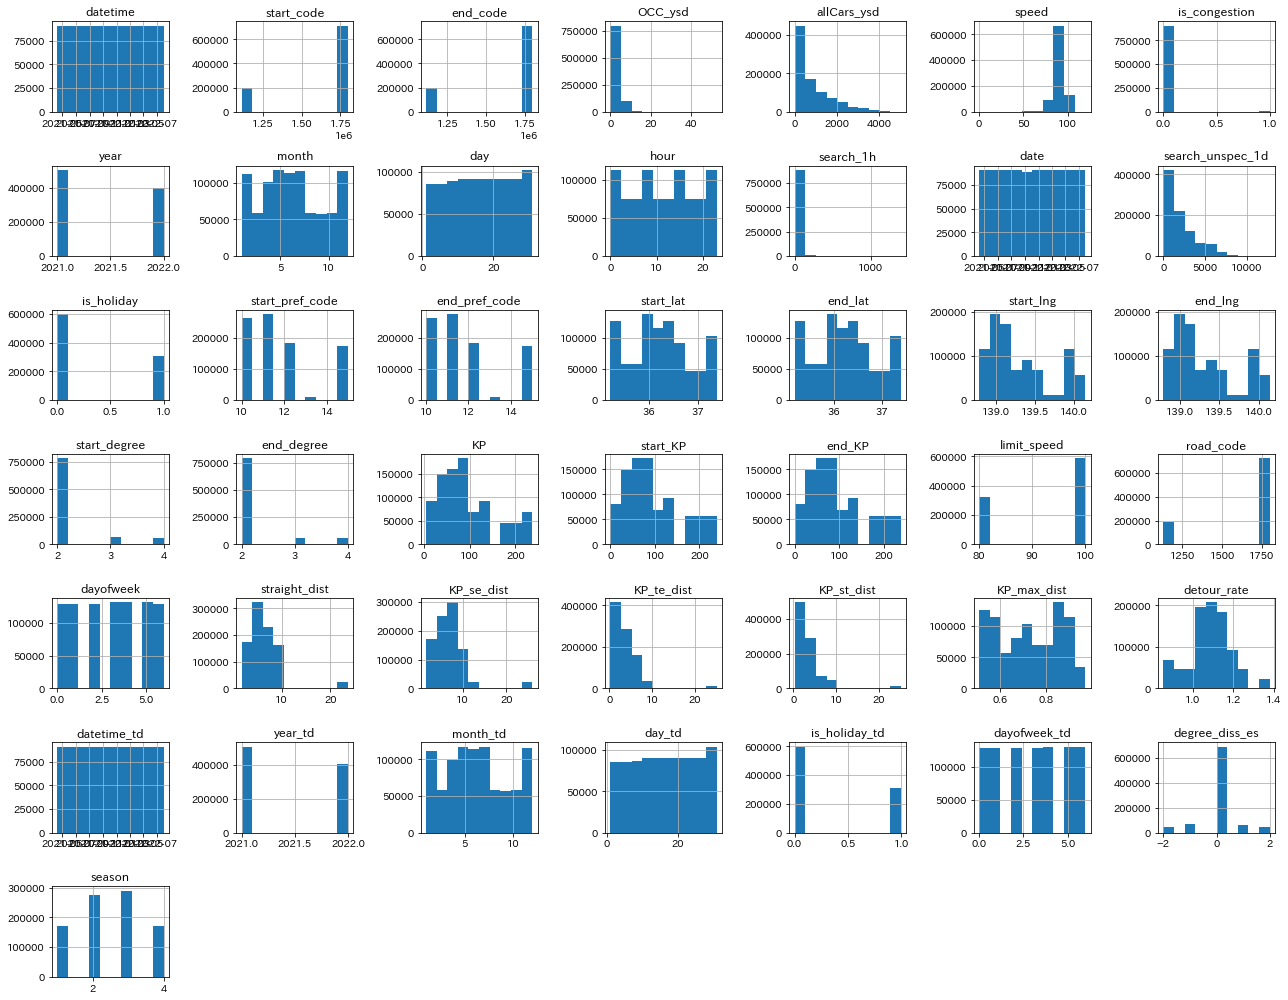

In [29]:
train.hist(figsize = (18,14)); # 一括でヒストグラムを描画する
plt.tight_layout() # グラフ同士が重ならないようにする関数
plt.show()

In [30]:
# ========================================
# カテゴリ変数の処理
# ========================================
le_dict = {}
for c in tqdm(cat_cols):
    le = LabelEncoder()
    le.fit(train[c])
    train[c] = le.transform(train[c])
    le_dict[c] = le

with open("../save/features/le_dict.pkl", "wb") as f:
    pickle.dump(le_dict, f)

100%|██████████| 11/11 [00:00<00:00, 11.30it/s]


In [31]:
# ========================================
# training module
# ========================================
def f1(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(int)
    score = f1_score(y_true, y_pred)
    return 'f1', score, True

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

def train_lgbm(X,
               y,
               cv,
               model_path = [],
               params: dict=None,
               verbose: int=100,
               weight_dict: dict=None,
               ):

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []

    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)

    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print(f'x_train shape: {x_train.shape}')
        print(f'x_valid shape: {x_valid.shape}')
        
        if weight_dict is None:
            print('Don\'t use sample weight.')
            lgb_train = lgb.Dataset(x_train, y_train)
        elif weight_dict[0] == 'balance':
            print('Using sample weight. {Balance}')
            lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
        else:
            print('Using sample weight.')
            print(weight_dict)
            lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight=weight_dict, y=y_train).astype('float32'))
            
        lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
        
        clf = lgb.train(params, lgb_train, 
                          valid_sets=[lgb_train, lgb_eval],
                          valid_names=['Train', 'Valid'],
                          feval=lgb_f1_score,
                          num_boost_round=100000,
                          verbose_eval=100,
                          categorical_feature=cat_cols,
                          callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]
                         )# categorical_feature=categories, verbose_eval=10
        
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = f1_score(y_valid, (pred_i > 0.5).astype(int))
        print(f" - fold{i + 1} - {score:.4f} \n")
        
    score = f1_score(y, (oof_pred > 0.5).astype(int))

    print("=" * 50)
    print(f"FINISH: CV Score: {score:.4f}")
    return score, oof_pred, models


In [32]:
train['is_congestion'].value_counts()

0.0    904135
1.0      4049
Name: is_congestion, dtype: int64

In [33]:
train['is_congestion'].value_counts() / len(train['is_congestion'])

0.0    0.995542
1.0    0.004458
Name: is_congestion, dtype: float64

In [34]:
vc = train['is_congestion'].value_counts()
vc[0]/vc[1]

223.29834527043715

In [35]:
# ========================================
# parameters
# ========================================
params = {
    'objective': 'binary',
    'verbose': -1,
    'metric': 'binary_logloss',
    'seed': 0,

    'num_leaves': 52, 
    'learning_rate': 0.01, 
    'max_depth': 9,
    'min_data_in_leaf': 10, 
    'feature_fraction': 0.9351779629995216, 
    'bagging_fraction': 0.6384393631575852, 
    'lambda_l1': 0.9764594650133958, 
    'lambda_l2': 0.4686512016477016
}# 'num_leaves' : int(0.7 * 2 ** max_depth)

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols]
y = train[TARGET]

print('train shape:', train.shape)

# ========================================
# training
# ========================================
weight = {0:1.0, 1:5.0}
score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)# 0.5814 <> shuffle 5810

train shape: (908184, 45)
x_train shape: (726168, 35)
x_valid shape: (182016, 35)
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logloss: 0.0422696	Train's f1: 0.548047	Valid's binary_logloss: 0.0207755	Valid's f1: 0.514798
[200]	Train's binary_logloss: 0.0312136	Train's f1: 0.651097	Valid's binary_logloss: 0.0166067	Valid's f1: 0.586288
[300]	Train's binary_logloss: 0.0258955	Train's f1: 0.673868	Valid's binary_logloss: 0.0149353	Valid's f1: 0.602056
[400]	Train's binary_logloss: 0.0228724	Train's f1: 0.684878	Valid's binary_logloss: 0.0143166	Valid's f1: 0.603827
Early stopping, best iteration is:
[345]	Train's binary_logloss: 0.0243879	Train's f1: 0.677345	Valid's binary_logloss: 0.0145905	Valid's f1: 0.615275
 - fold1 - 0.6153 

x_train shape: (726168, 35)
x_valid shape: (182016, 35)
Using sample weight.
{0: 1.0, 1: 5.0}
Training until validation scores don't improve for 100 rounds.
[100]	Train's binary_logl

In [36]:
for i, m in enumerate(models):
   with open(f"../save/model/lgbm_fold{i}.pkl", mode="wb") as f:
      pickle.dump(m, f)

In [37]:
oof_pred.shape

(908184,)

In [38]:
train['is_congestion'].value_counts

<bound method IndexOpsMixin.value_counts of 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
910051    0.0
910052    0.0
910053    0.0
910054    0.0
910055    0.0
Name: is_congestion, Length: 908184, dtype: float64>

In [39]:
print(classification_report(train['is_congestion'], np.round(oof_pred)))
print(train['is_congestion'].sum(), oof_pred.sum())

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    904135
         1.0       0.69      0.50      0.58      4049

    accuracy                           1.00    908184
   macro avg       0.85      0.75      0.79    908184
weighted avg       1.00      1.00      1.00    908184

4049.0 10592.851


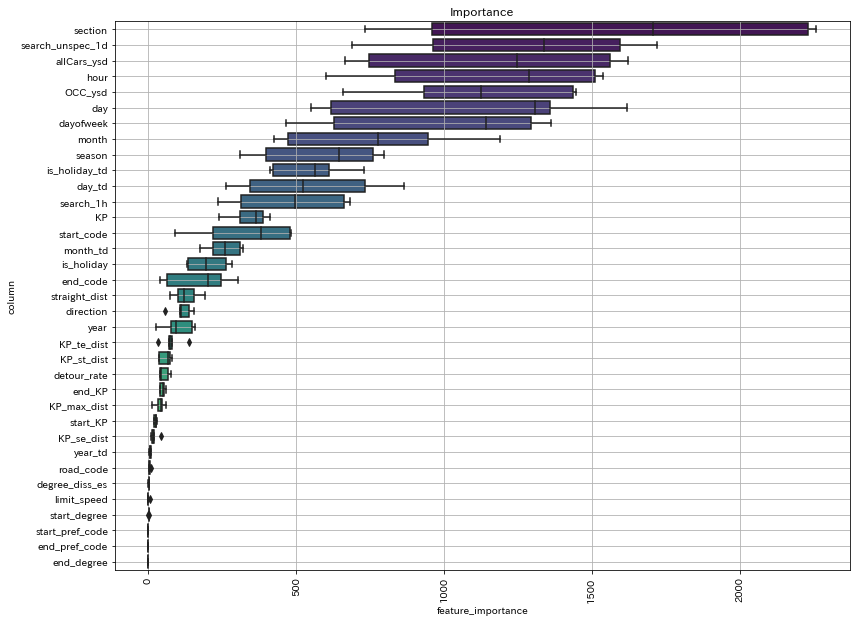

In [40]:
# ========================================
# feature importance
# ========================================
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        importance_type = 'split'
        _df["feature_importance"] = model.feature_importance(importance_type=importance_type)
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df],
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby("column")\
        .sum()[["feature_importance"]]\
        .sort_values("feature_importance", ascending=False).index

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * .25)))
    sns.boxplot(data=feature_importance_df,
                  x="feature_importance",
                  y="column",
                  order=order,
                  ax=ax,
                  palette="viridis",
                  orient="h")
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax, feature_importance_df

fig, ax, feature_importance_df = visualize_importance(models, train[feature_cols])

In [41]:

def train_lgbm(X, y, cv):
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        train_date = x_train['date']
        #print(f'Train: {train_date.min()} >> {train_date.max()}')
        #print(x_train.shape)
        #print(y_train.value_counts())

        valid_date = x_valid['date']
        print(f'Validation: {valid_date.min()} >> {valid_date.max()}')
        #print(x_valid.shape)
        #print(y_valid.value_counts())

# ========================================
# train-validation split
# ========================================
TARGET = 'is_congestion'
N_SPLIT = 5
kf = StratifiedGroupKFold(N_SPLIT)
cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

# ========================================
# define variables
# ========================================
X = train[feature_cols+['date']]
y = train[TARGET]

print(X.shape)
print(y.shape)

train_lgbm(X, y, cv_list)

(908184, 36)
(908184,)
Validation: 2021-04-09 00:00:00 >> 2022-07-26 00:00:00
Validation: 2021-04-13 00:00:00 >> 2022-07-29 00:00:00
Validation: 2021-04-08 00:00:00 >> 2022-07-30 00:00:00
Validation: 2021-04-10 00:00:00 >> 2022-07-18 00:00:00
Validation: 2021-04-11 00:00:00 >> 2022-07-28 00:00:00


In [42]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.8 MB/s eta 0:00:00


In [43]:
def train_lgbm(X,
               y,
               cv,
               model_path = [],
               params: dict=None,
               verbose: int=100,
               weight_dict: dict=None,
               ):

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    n_records = len(X)
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros((n_records, ), dtype=np.float32)
    
    for i, (idx_train, idx_valid) in enumerate(cv):
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        
        if weight_dict is None:
            print('Don\'t use sample weight.')
            lgb_train = lgb.Dataset(x_train, y_train)
        elif weight_dict[0] == 'balance':
            print('Using sample weight. {Balance}')
            lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
        else:
            print('Using sample weight.')
            print(weight_dict)
            lgb_train = lgb.Dataset(x_train, y_train, weight=compute_sample_weight(class_weight=weight_dict, y=y_train).astype('float32'))
            
        lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)
        
        clf = lgb.train(params, lgb_train, 
                          valid_sets=[lgb_train, lgb_eval],
                          valid_names=['Train', 'Valid'],
                          feval=lgb_f1_score,
                          num_boost_round=100000,
                          verbose_eval=-1,
                          categorical_feature=cat_cols,
                          callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]
                         )# categorical_feature=categories, verbose_eval=10
        
        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        score = f1_score(y_valid, (pred_i > 0.5).astype(int))
        print(f" - fold{i + 1} - {score:.4f} \n")
        
    score = f1_score(y, (oof_pred > 0.5).astype(int))

    print("=" * 50)
    print(f"FINISH: CV Score: {score:.4f}")
    return score, oof_pred, models

In [44]:
if False:
    import optuna
    TUNE_SEED_NUM = 1

    def objective(trial):
        
        params = {
            'objective': 'binary',
            'verbose': -1,
            'metric': 'binary_logloss',
            'seed': 0,
            "force_col_wise":True,
            
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.6, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.6, 1.0),
            'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 1),
            'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 1),
        
        }

        # ========================================
        # train-validation split
        # ========================================
        TARGET = 'is_congestion'
        N_SPLIT = 5
        kf = StratifiedGroupKFold(N_SPLIT)
        cv_list = list(kf.split(train, y=train[TARGET], groups=train['date']))

        # ========================================
        # define variables
        # ========================================
        X = train[feature_cols]
        y = train[TARGET]

        vc = train['is_congestion'].value_counts()

        weight = {0:1.0, 1:5.0}
        score, oof_pred, models = train_lgbm(X, y=y, params=params, cv=cv_list, weight_dict=weight)
            
        return -score
        
    study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
    study.optimize(objective, n_trials=100)
    print(study.best_params)